In [1]:
import nbformat

notebook_path = "Relevant Segment Extraction.ipynb"

nb = nbformat.read(notebook_path, as_version=4)

if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

nbformat.write(nb, notebook_path)

print("Fixed!")


Fixed!


In [1]:
!pip install langchain-community langchain-text-splitters langchain-ollama pypdf ollama langchain-huggingface sentence-transformers  --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 34.7 MB/s eta 0:00:00


In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from scipy.stats import beta
from sentence_transformers import CrossEncoder
import numpy as np
import matplotlib.pylab as plt
from typing import List
from langchain_community.document_loaders import PyPDFLoader


In [3]:
model_name="BAAI/bge-reranker-v2-m3"
reranker=CrossEncoder(model_name)




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [8]:
query="What the CRAG proposed to improve"
path=r"/content/drive/MyDrive/RAG/RAG資料集/2401.15884v3.pdf"
Chunk_size=512
chunk_overlap=0

In [6]:
def texts_into_chunks(path,chunk_size,chunk_overlap):
    loader=PyPDFLoader(path)
    document=loader.load()

    texts_splitter=RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        )
    documents=texts_splitter.split_documents(document)

    return [document.page_content for document in documents]

def transform(x):
    a,b=0.4,0.4
    return beta.cdf(x,a,b)

def rerank_chunks(query,chunks,reranker):

    decay_rate = 30

    pairs=[(query,chunk) for chunk in chunks]
    scores=reranker.predict(pairs)
    reranked_indices=sorted(
        range(len(scores)),
        key=lambda i:scores[i],
        reverse=True
    )

    similarity_scores = [0.0] * len(chunks)
    chunk_values = [0.0] * len(chunks)

    for rank, index in enumerate(reranked_indices):
        absolute_relevance_value = transform(scores[index])
        similarity_scores[index] = absolute_relevance_value

        chunk_values[index] = np.exp(-rank / decay_rate) * absolute_relevance_value

    return similarity_scores, chunk_values

def plot_relevance_scores(chunk_values : List[float], start_index=None, end_index=None):
    plt.figure(figsize=(12,5))
    plt.title("Similarity of each chunk in the document to the search query")
    plt.ylim(0,1) #固定y的尺寸
    plt.xlabel("Chunk_index")
    plt.ylabel("Query-chunk similarity")
    if start_index is None:
        start_index=0
    if end_index is None:
        end_index=len(chunk_values)

    plt.scatter(range(start_index, end_index), chunk_values[start_index:end_index])



In [7]:
chunks = texts_into_chunks(path,Chunk_size,chunk_overlap)
print (f"Split the document into {len(chunks)} chunks")

Split the document into 131 chunks


In [9]:
similarity_scores, chunk_values = rerank_chunks(query,chunks,reranker)

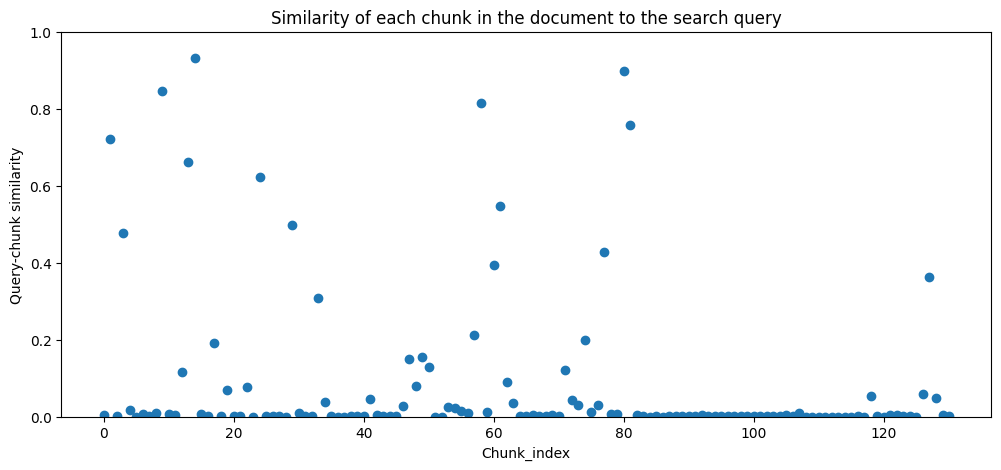

In [10]:
plot_relevance_scores(chunk_values)

從一篇被切成很多 chunk 的文件中，根據「chunk 的相關分數」，自動挑出「幾段連續 chunk」，讓總相關度最高

In [18]:
def get_best_segments(relevance_values: list, max_length: int, overall_max_length: int, minimum_value: float):
    """
    This function takes the chunk relevance values and then runs an optimization algorithm to find the best segments. In more technical terms, it solves a constrained version of the maximum sum subarray problem.

    Note: this is a simplified implementation intended for demonstration purposes. A more sophisticated implementation would be needed for production use and is available in the dsRAG library.

    Args:
        relevance_values (list): a list of relevance values for each chunk of a document
        max_length (int): the maximum length of a single segment (measured in number of chunks)
        overall_max_length (int): the maximum length of all segments (measured in number of chunks)
        minimum_value (float): the minimum value that a segment must have to be considered

    Returns:
        best_segments (list): a list of tuples (start, end) that represent the indices of the best segments (the end index is non-inclusive) in the document
        scores (list): a list of the scores for each of the best segments
    """
    best_segments = []
    scores = []
    total_length = 0
    while total_length < overall_max_length:
        # find the best remaining segment
        best_segment = None
        best_value = -1000
        for start in range(len(relevance_values)):
            # skip over negative value starting points
            if relevance_values[start] < 0:
                continue
            for end in range(start+1, min(start+max_length+1, len(relevance_values)+1)):
                # skip over negative value ending points
                if relevance_values[end-1] < 0:
                    continue
                # check if this segment overlaps with any of the best segments and skip if it does
                if any(start < seg_end and end > seg_start for seg_start, seg_end in best_segments):
                    continue
                # check if this segment would push us over the overall max length and skip if it would
                if total_length + end - start > overall_max_length:
                    continue

                # define segment value as the sum of the relevance values of its chunks
                segment_value = sum(relevance_values[start:end])
                if segment_value > best_value:
                    best_value = segment_value
                    best_segment = (start, end)

        # if we didn't find a valid segment then we're done
        if best_segment is None or best_value < minimum_value:
            break

        # otherwise, add the segment to the list of best segments
        best_segments.append(best_segment)
        scores.append(best_value)
        total_length += best_segment[1] - best_segment[0]

    return best_segments, scores

In [19]:
# define some parameters and constraints for the optimization
irrelevant_chunk_penalty = 0.2 # empirically, something around 0.2 works well; lower values bias towards longer segments
max_length = 20
overall_max_length = 30
minimum_value = 0.7

# subtract constant threshold value from chunk relevance values
relevance_values = [v - irrelevant_chunk_penalty for v in chunk_values]

# run the optimization
best_segments, scores = get_best_segments(relevance_values, max_length, overall_max_length, minimum_value)

# print results
print ("Best segment indices")
print (best_segments) # indices of the best segments, with the end index non-inclusive
print ()
print ("Best segment scores")
print (scores)
print ()

Best segment indices
[(9, 15), (80, 82), (57, 62)]

Best segment scores
[np.float64(1.3615340434766776), np.float64(1.254180559380992), np.float64(0.9801212031596165)]



查看選擇範圍的文章

In [21]:
def print_document_segment(chunks: List[str], start_index: int, end_index: int):
    """
    Print the text content of a segment of the document
    """
    for i in range(start_index, end_index):
        print(f"\nChunk {i}")
        print(chunks[i])

print_document_segment(chunks, 80, 82)


Chunk 80
thereby exposing inaccurate and misleading knowl-
edge to generative LMs. Corrective Retrieval
Augmented Generation is proposed to improve the
robustness of generation. Essentially, a lightweight
retrieval evaluator is to estimate and trigger three
knowledge retrieval actions discriminately. With
the further leverage of web search and optimized
knowledge utilization, CRAG has significantly
improved the ability of automatic self-correction
and efficient utilization of retrieved documents.

Chunk 81
Experiments extensively demonstrate its adaptabil-
ity to RAG-based approaches as well as general-
izability across short- and long-form generation
tasks. While we primarily proposed to improve the
RAG framework from a corrective perspective and
CRAG can be seamlessly coupled with various
RAG-based approaches, fine-tuning an external
retrieval evaluator is inevitable. How to eliminate
this external evaluator and equip LLMs with better
retrieval evaluation capabilities will be our fu